In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats import kurtosis
from scipy.stats import skew
from scipy.stats import kstest
import matplotlib.pyplot as plt
import statsmodels.api as sm
import datetime
import matplotlib.pyplot as plt
import cvxopt as cvxopt
from cvxopt import blas, solvers, matrix

/Users/apple/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
xls = pd.ExcelFile('HW1_599.xlsx')
df = pd.read_excel(xls, 'DataSource', parse_dates=[0,3])

In [3]:
df = df.drop(['Unnamed: 2'], axis=1)
df.columns = df.iloc[0]
df = df[1:]
df.columns = ['vix_date', 'vix_price', 'spy_date','spy_price']

In [4]:
df.head()

,vix_date,vix_price,spy_date,spy_price
1,1999-01-15 00:00:00,29.24,1999-01-15 00:00:00,124.375
2,1999-01-19 00:00:00,29.24,1999-01-19 00:00:00,125.188
3,1999-01-20 00:00:00,28.6,1999-01-20 00:00:00,126.188
4,1999-01-21 00:00:00,30.92,1999-01-21 00:00:00,122.844
5,1999-01-22 00:00:00,31.95,1999-01-22 00:00:00,122.562


## 1.1 VIX daily return

In [5]:
df['vix_ret'] = df['vix_price'].pct_change()

In [6]:
df.head()

,vix_date,vix_price,spy_date,spy_price,vix_ret
1,1999-01-15 00:00:00,29.24,1999-01-15 00:00:00,124.375,NaN
2,1999-01-19 00:00:00,29.24,1999-01-19 00:00:00,125.188,0.000000
3,1999-01-20 00:00:00,28.6,1999-01-20 00:00:00,126.188,-0.021888
4,1999-01-21 00:00:00,30.92,1999-01-21 00:00:00,122.844,0.081119
5,1999-01-22 00:00:00,31.95,1999-01-22 00:00:00,122.562,0.033312


## 1.2 moments (mean,skewness, and kurtosis) for the VIX daily returns

In [7]:
np.mean(df['vix_ret'][1:])

0.002357136485960589

In [8]:
np.std(df['vix_ret'][1:])

0.07134192299501821

In [9]:
skew(df['vix_ret'][1:])

2.0141811943320107

In [10]:
kurtosis(df['vix_ret'][1:])

19.282112081195784

## 1.3 test whether the VIX daily returns were normally distributed or not. 

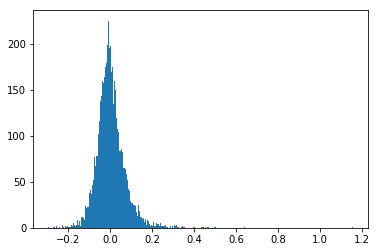

In [11]:
plt.hist(df['vix_ret'][1:],bins=300)
plt.show()

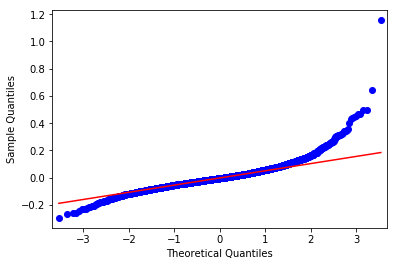

In [12]:
sm.qqplot(df['vix_ret'][1:], line='q')
plt.show()

In [13]:
kstest(df['vix_ret'][1:],'norm')

KstestResult(statistic=0.43284430209658664, pvalue=0.0)

Pvalue of KS test less than 0.05 so we can reject null. It is not normal distributed 

## 2.1  rolling 252-day annualied SPY return volatilities, and plot the time series

In [14]:
df['spy_ret'] = df['spy_price'].pct_change()

In [15]:
df['252_spy_vol'] = df['spy_ret'].rolling(252).std()*np.sqrt(252)

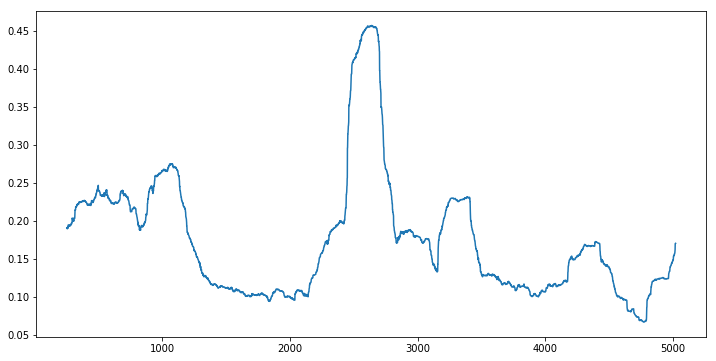

In [16]:
plt.figure(figsize=(12,6))
df['252_spy_vol'].plot()
plt.show()

## 2.2  rolling 252-day annualied SPY return semi-volatilities, and plot the time series

In [17]:
df['spy_ret_neg'] = df[df['spy_ret']<0]['spy_ret']
df['spy_ret_neg'] = df['spy_ret_neg'].fillna(0)

In [18]:
df['252_spy_semivol'] = df['spy_ret_neg'].rolling(252).std()*np.sqrt(252)

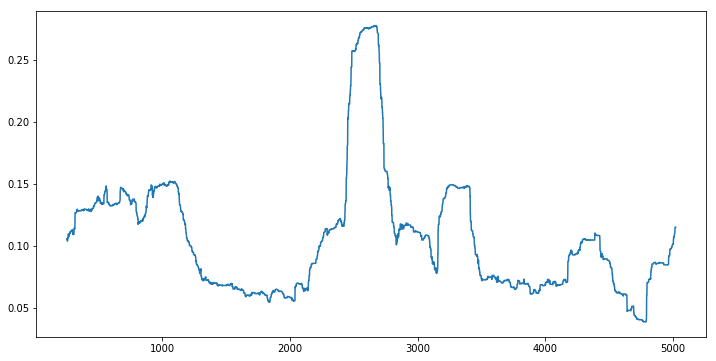

In [19]:
plt.figure(figsize=(12,6))
df['252_spy_semivol'].plot()
plt.show()

## 2.3 A). calculate its shortfall probability for a daily return less than -2%; B). Value at Risk at 95% for daily return; C). CVaR-95% for daily return.

In [20]:
df['spy_year'] = pd.to_datetime(df['spy_date']).dt.to_period('Y').astype(str)

In [21]:
df2018 = df[df['spy_year']=='2018']

In [22]:
df2018.head()

,vix_date,vix_price,spy_date,spy_price,vix_ret,spy_ret,252_spy_vol,spy_ret_neg,252_spy_semivol,spy_year
4772,2018-01-02 00:00:00,9.77,2018-01-02 00:00:00,268.77,-0.115036,0.007157,0.067881,0.0,0.039094,2018
4773,2018-01-03 00:00:00,9.15,2018-01-03 00:00:00,270.47,-0.063460,0.006325,0.067758,0.0,0.039094,2018
4774,2018-01-04 00:00:00,9.22,2018-01-04 00:00:00,271.61,0.007650,0.004215,0.067646,0.0,0.039094,2018
4775,2018-01-05 00:00:00,9.22,2018-01-05 00:00:00,273.42,0.000000,0.006664,0.067889,0.0,0.039110,2018
4776,2018-01-08 00:00:00,9.52,2018-01-08 00:00:00,273.92,0.032538,0.001829,0.067838,0.0,0.039110,2018


In [23]:
shortfall_probdf = len(df2018[df2018['spy_ret']<-0.02])/len(df2018['spy_ret'])

In [24]:
shortfall_probdf

0.055776892430278883

In [25]:
var = df2018['spy_ret'].quantile(0.05, interpolation='higher')
var

-0.021314521940304143

In [26]:
cvar = df2018[df2018['spy_ret']<var]['spy_ret'].mean()
cvar

-0.02786116034896852

## 2.4 Calculate drawdowns for the SPY price times series, plot the drawdown time series, and locate the maximum drawdown for the whole period

In [27]:
df['drawdown']=(df['spy_ret']+1).cumprod()/(df['spy_ret']+1).cumprod().cummax()-1

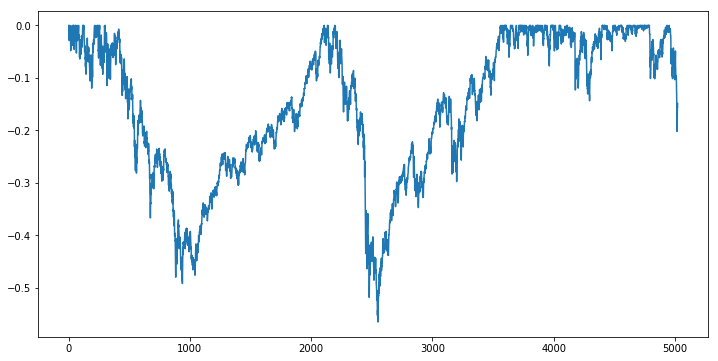

In [28]:
plt.figure(figsize=(12,6))
df['drawdown'].plot()
plt.show()

In [29]:
df[df['drawdown']==np.min(df['drawdown'])][['spy_date','drawdown']]

,spy_date,drawdown
2551,2009-03-09 00:00:00,-0.564737


## 3.1 Run an optimization to locate the minimum-variance portfolio on the new frontier.

In [40]:
df2 = pd.read_excel(xls, 'DataSource_CAPMAssetClasses', parse_dates=[0,3])
df2.columns = df2.iloc[0]
df2 = df2[1:]
cols = df2.columns
df2[cols] = df2[cols].apply(pd.to_numeric, errors='coerce', axis=1)

In [41]:
df2.head()

Period Ending,Bloomberg Barclays - U.S. TIPS Index,Bloomberg Barclays - U.S. Aggregate Index,BofA Merrill Lynch - U.S. High Yield Index,FTSE - Non U.S. Govt Bond Index ($),Russell - 1000 Growth Index,Russell - 1000 Value Index,Russell - 2000 Growth Index,Russell - 2000 Value Index,MSCI - EAFE Index ($Net),MSCI - Emerging Markets Index ($ Net),S&P - GSCI Total Index,MSCI - U.S. REIT Index
1999-01-31 00:00:00,1.164369,0.71,1.35,-1.57,5.87,0.80,4.50,-2.27,-0.30,-1.507453,0.440000,-2.685540
1999-02-28 00:00:00,-0.698657,-1.75,-0.68,-3.51,-4.57,-1.41,-9.15,-6.83,-2.38,0.963531,-4.600000,-1.644916
1999-03-31 00:00:00,-0.014495,0.55,1.16,0.19,5.27,2.07,3.56,-0.82,4.17,13.214558,16.879999,-0.545957
1999-04-30 00:00:00,0.661948,0.32,1.83,-0.15,0.13,9.34,8.83,9.13,4.05,12.370000,4.130000,9.669238
1999-05-31 00:00:00,0.688692,-0.88,-0.92,-2.02,-3.07,-1.10,0.16,3.07,-5.15,-0.580000,-5.460000,2.119436


In [42]:
def optimize_portfolio(n, avg_ret, covs,r_min):
    P = matrix(covs)
    q=matrix(np.zeros(n))
    G=matrix(-1*np.eye(n)) 
    h=matrix(np.zeros(n))
    A=matrix(np.array([avg_ret,np.ones(n)]))
    b = matrix([r_min,1.0])
    sol = cvxopt.solvers.qp(P,q,G,h,A,b,options={'show_progress':False})
    weight = list(sol['x'])
    std=np.sqrt(sol['primal objective']*2)
    return std,weight

In [43]:
def optimize_portfolio_with_short(n, avg_ret, covs,r_min):
    P = matrix(covs)
    q=matrix(np.zeros(n))
    G=matrix(np.zeros([n,n])) 
    h=matrix(np.zeros(n))
    A=matrix(np.array([avg_ret,np.ones(n)]))
    b = matrix([r_min,1.0])
    sol = cvxopt.solvers.qp(P,q,G,h,A,b,options={'show_progress':False})
    weight = list(sol['x'])
    std=np.sqrt(sol['primal objective']*2)
    return std,weight

In [44]:
n = 12
means=np.array(df2.mean()*n)
means

array([  5.2451825 ,   4.5136965 ,   6.53156295,   3.6777377 ,
         6.34985075,   7.05579735,   8.4745013 ,   9.5519761 ,
         4.81835   ,  10.60893805,   3.14656425,  11.49096465])

In [45]:
covs=np.array(df2.cov()*n)
means=np.array(df2.mean()*n)
ret = [x/100 for x in range(300,1200)]
std_f = 1000
weight_minvar = np.zeros(12)
ret_opt = 0
for r_min in ret:
    std,weight= optimize_portfolio(n, means, covs,r_min)
    if std<std_f:
        std_f = std
        weight_minvar = weight
        ret_opt = r_min

In [46]:
ret_opt

4.65

In [47]:
weight_minvar

[1.3283671929434165e-09,
 0.9264906042241658,
 2.3901012041696376e-10,
 5.954146825090524e-10,
 0.012958812690184365,
 0.03888401488205899,
 0.008123782555722901,
 1.0391869580860733e-08,
 1.2706961361350939e-09,
 2.992437814136145e-09,
 0.013542768726797563,
 1.0327484266094103e-10]

## 2A. Run optimizations to locate two other efficient portfolios different than the minimum-variance portfolio

In [48]:
ret1 = 6
std1,weight1= optimize_portfolio(n, means, covs,ret1)
weight1

[0.15478751283432524,
 0.6131735465888063,
 2.19510021555986e-07,
 7.929680577462979e-11,
 1.7019893115432124e-09,
 9.478356397230582e-10,
 4.848937926184835e-10,
 0.09847953326209054,
 -1.8977647678661317e-10,
 0.06231953422593871,
 3.7822013467628684e-09,
 0.07123964677237725]

In [49]:
ret2 = 8
std2,weight2= optimize_portfolio(n, means, covs,ret2)
weight2

[0.5117631076745152,
 7.488884320521562e-07,
 1.1700625002119294e-07,
 1.550561404239225e-08,
 1.2430383541211578e-08,
 2.025382891265965e-08,
 2.134597643211013e-08,
 0.08398574184705136,
 6.361663441648602e-09,
 0.14937185681382253,
 2.8408681431801363e-08,
 0.25487832346378114]

## 2B. Prove or disprove the minimum-variance portfolio can be represented as a combination of the two portfolios found on 2A.

define new_weight = w * weight1 + (1-w) * weight2 
then calculate return and volatility respectvely, the new_weight still the minimum variance weight
Therefore, I prove that minimum-variance portfolio can be represented as a combination of the two portfolios found on 2A


## 3. Plot both the old efficient frontier without the short-sell constraint and the new efficient frontier with the short-sell constraint on the same graph.

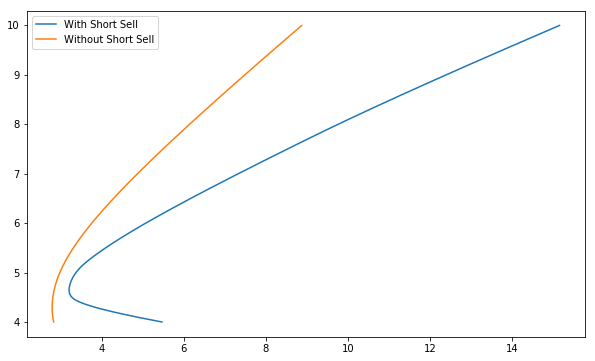

In [50]:
stds = []
rets = []
weights = []
stds2 = []
rets2 = []
weights2 = []
ret2 = [x/1000 for x in range(4000,10000)]
for r_min in ret2:
    std,weight= optimize_portfolio(n, means, covs,r_min)
    stds.append(std)
    weights.append(weight)
    rets.append(r_min)
for r_min in ret2:
    std,weight= optimize_portfolio_with_short(n, means, covs,r_min)
    stds2.append(std)
    weights2.append(weight)
    rets2.append(r_min)
plt.figure(figsize=[10,6])
plt.plot(stds,rets,label='With Short Sell')
plt.plot(stds2,rets2,label='Without Short Sell')
plt.legend()
plt.show()